In [1]:
pip install pymatgen

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import pymatgen.core as pmg

In [3]:
df_main = pd.read_csv("Datasets\prepr_.csv")

# Pymatgen descriptors

Now we will use library pymatgen to get additional descriptors for catalysts

In [4]:
ion_energy = dict()
products = set()

products = products.union(set(df_main["Cat. compound"].unique()))
products = products.union(set(df_main["Support"].unique()))
products.remove("No")
products = list(products)

ion_energy["Formulas"] = products
ion_energy["Formulas"]

['Au', 'Cu2O', 'Cu(OH)2', 'Cu3N', 'Cu', 'Ag', 'N', 'Pd', 'CuO']

Now manually I add 2 rows, that corresponds to:
1. Main metall in the compound
2. Oxidation state of this metall

In [5]:
ion_energy["Free form"] = ['Cu', 'Pd', 'N', 'Cu', 'Cu', 'Cu', 'Au', 'Cu', 'Ag']
ion_energy["Oxidation state"] = [1, 0, 0, 2, 0, 2, 0, 1, 0]

Now I am adding information about the energy of ionization of corresponsing element

In [6]:
ion_energy["Energy of +1 ion"] = [pmg.Element(ion_energy["Free form"][i]).ionization_energies[ion_energy["Oxidation state"][i]] for i in range(0, len(ion_energy["Free form"]))]

Calculating an ion radius, if the element isn't in oxidation state 0, otherwise calcualte atomic radius

In [7]:
ion_energy["Radius"] = []
for i in range(0, len(ion_energy["Energy of +1 ion"])):
    ox_state = ion_energy["Oxidation state"][i]
    el = ion_energy["Free form"][i]
    if ion_energy["Oxidation state"][i] == 0:
        ion_energy["Radius"].append(pmg.Element(el).atomic_radius)
    else:
        ion_energy["Radius"].append(pmg.Element(el).ionic_radii[ox_state])   

This data can be modified to the Dataframe

In [8]:
dict_ions = dict()
for i in range(0, len(ion_energy["Formulas"])):
    dict_ions[ion_energy["Formulas"][i]] = {"Energy of +1 ion": ion_energy["Energy of +1 ion"][i],
                                            "Radius": ion_energy["Radius"][i]}
dict_ions["No"] = {"Energy of +1 ion": 0,
                    "Radius": 0}

Now we formed a dataset, which rows are taken from the original dataset

In [9]:
ion_df = pd.DataFrame()
for catal in ["Cat. compound", "Support"]:
    for_df = {catal + "_Energy of +1 ion": [],
              catal + "_Metal_radius": []}
    for i in range(0, len(df_main)):
        comp = df_main.at[i, catal]
        for_df[catal + "_Energy of +1 ion"].append(dict_ions[comp]["Energy of +1 ion"])
        for_df[catal + "_Metal_radius"].append(dict_ions[comp]["Radius"])

    new = pd.DataFrame(data = for_df)
    print(new.columns)
    if len(ion_df) == 0:
        ion_df = new.copy()
    else:
        ion_df = pd.concat([ion_df, new], axis=1, join="inner")
ion_df.head()

Index(['Cat. compound_Energy of +1 ion', 'Cat. compound_Metal_radius'], dtype='object')
Index(['Support_Energy of +1 ion', 'Support_Metal_radius'], dtype='object')


,Cat. compound_Energy of +1 ion,Cat. compound_Metal_radius,Support_Energy of +1 ion,Support_Metal_radius
0,8.336839,1.4,0.0,0.0
1,8.336839,1.4,0.0,0.0
2,8.336839,1.4,0.0,0.0
3,8.336839,1.4,0.0,0.0
4,8.336839,1.4,0.0,0.0


# Rdkit and pubchempy descriptors

## Library loading

In [10]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

import pubchempy as pcp

We need to check, is every compound can be get from rdkit

In [12]:
CIDa = []
cmp = list(products)
cid_dict = dict()
for np in cmp:
  for compound in pcp.get_compounds(np, 'name'):
    CIDa.append(compound.cid)
    print(np, compound.cid)
    cid_dict[np] = compound.cid

Au 23985
Cu2O 10313194
Cu(OH)2 30154
Cu 23978
Ag 23954
N 947
Pd 23938
CuO 14829


In [13]:
def check():
    not_missing = True
    for mat in products:
        if mat not in cid_dict.keys():
            not_missing = False
            print(f"You need to add {mat}")
    if not_missing:
        print("Everything is fine")
check()

You need to add Cu3N


In [14]:
cid_dict["Cu3N"] = 56841037

By CID of compounds it is possible to get SMILES type of molecule descriptor, by wich we can get rdkit descriptors

In [15]:
comp_smiles = dict()
for comp, cid in cid_dict.items():
    c = pcp.Compound.from_cid(cid)
    comp_smiles[comp] = c.canonical_smiles

Now we form a dataset of rdkit prtoperties of all compounds by their smiles

In [16]:
import numpy as np
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = rdMolDescriptors.Properties(descriptor_names)
num_descriptors = len(descriptor_names)

descriptors_set = np.empty((0, num_descriptors), float)

for _, value in comp_smiles.items():
    molecule = Chem.MolFromSmiles(value)
    descriptors = np.array(get_descriptors.ComputeProperties(molecule)).reshape((1,num_descriptors))
    descriptors_set = np.append(descriptors_set, descriptors, axis=0)

In [17]:
df_comp = pd.Series(data=comp_smiles.keys())

In [18]:
df_rdkit = pd.DataFrame(descriptors_set, columns= descriptor_names)
combinedd = pd.concat([df_comp, df_rdkit], axis =1, join='inner')
combinedd = combinedd.loc[:, combinedd.nunique() > 1]
combinedd

,0,exactmw,amw,lipinskiHBA,lipinskiHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,labuteASA,...,CrippenMR,chi0v,chi1v,chi0n,chi1n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,Au,196.966569,196.967,0.0,0.0,0.0,1.0,1.0,1.0,23.001881,...,0.0000,2.467977,0.000000,0.301511,0.000000,0.740260,1.740260,0.091137,2.143769,0.158602
1,Cu2O,141.854110,143.091,1.0,0.0,0.0,3.0,3.0,3.0,40.040472,...,0.6865,2.894575,0.000000,1.011271,0.000000,0.998961,36.040576,12.008324,2.998961,144.262298
2,Cu(OH)2,98.950727,99.576,2.0,4.0,0.0,3.0,7.0,3.0,28.925605,...,7.2276,2.243163,0.000000,1.301511,0.000000,0.439481,105.976191,26.171564,2.439481,924.520892
3,Cu,62.929597,63.546,0.0,0.0,0.0,1.0,1.0,1.0,17.964098,...,0.0000,1.243163,0.000000,0.301511,0.000000,0.519481,1.519481,0.444481,4.219481,0.675379
4,Ag,106.905097,107.868,0.0,0.0,0.0,1.0,1.0,1.0,23.001881,...,0.0000,1.783765,0.000000,0.301511,0.000000,0.740260,1.740260,0.091137,2.143769,0.158602
5,N,28.006148,28.014,2.0,0.0,2.0,2.0,2.0,2.0,12.124588,...,3.4500,0.894427,0.200000,0.894427,0.200000,-0.580000,1.420000,0.420000,-4.304138,0.298200
6,Pd,105.903486,106.420,0.0,0.0,0.0,1.0,1.0,1.0,21.147744,...,0.0000,1.870829,0.000000,0.316228,0.000000,0.662338,1.662338,0.172142,2.701553,0.286157
7,CuO,78.924512,79.545,1.0,0.0,1.0,2.0,2.0,2.0,20.679422,...,0.6865,1.651411,0.507519,0.709760,0.123091,0.319481,2.319481,1.319481,1.449562,1.530255
8,Cu3N,204.807517,206.661,1.0,2.0,0.0,4.0,6.0,4.0,57.291089,...,5.2844,4.306840,0.000000,1.481884,0.000000,1.518442,48.864969,24.260134,9.678720,296.367668


It is so many descriptors so we need to drop high-correlated 

In [19]:
def corr_col(df, val):
    corr_matrix = df.corr(method="spearman").abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > val)]
    return to_drop

In [20]:
num_col = combinedd.select_dtypes(include=["float64", "int64"]).columns.to_list()
comb_low_cor = combinedd.drop(corr_col(combinedd[num_col], 0.9), axis=1).copy()
num_col = comb_low_cor.select_dtypes(include=["float64", "int64"]).columns.to_list()
comb_low_cor.shape

(9, 10)

it is only 9 descriptors remaining, so lets visualize correlation matrix

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

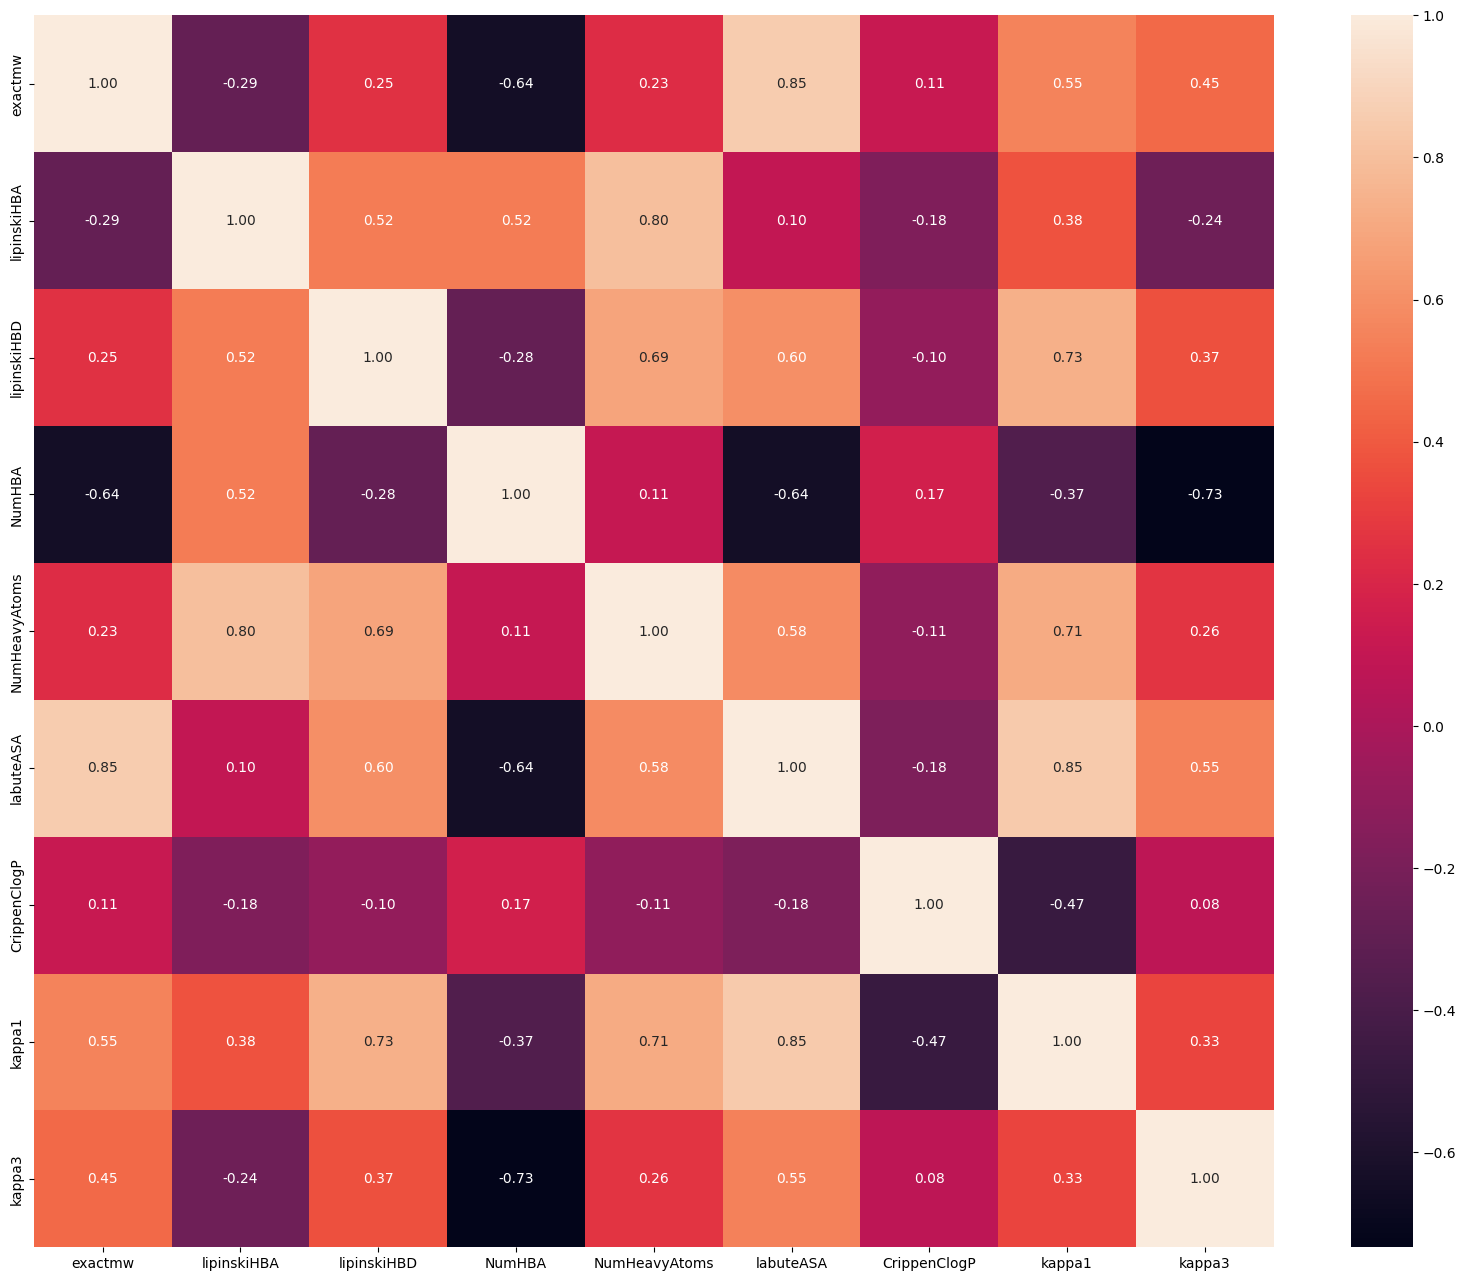

In [22]:
plt.figure(figsize=(20, 16))
sns.heatmap(comb_low_cor[num_col].corr(method="spearman"), annot=True, fmt=".2f", annot_kws={"size": 10})

Now we need to fill our main dataset by the descriptors for 2 columns: "Support", "Cat. compound". To fastem algorithm we will form a dictionary, which will provide descriptors by formula

In [23]:
combinedd = comb_low_cor.copy()

In [24]:
rdkit_dict = dict()
for i in range(0, len(combinedd)):
    rdkit_dict[combinedd.loc[i, 0]] = dict()
    for col in combinedd.columns[1:]:
        rdkit_dict[combinedd.loc[i, 0]][col] = combinedd.loc[i, col]
rdkit_dict["No"] = {col: 0 for col in combinedd.columns[1:]}
rdkit_dict

{'Au': {'exactmw': np.float64(196.9665687),
  'lipinskiHBA': np.float64(0.0),
  'lipinskiHBD': np.float64(0.0),
  'NumHBA': np.float64(0.0),
  'NumHeavyAtoms': np.float64(1.0),
  'labuteASA': np.float64(23.001880613197383),
  'CrippenClogP': np.float64(-0.0025),
  'kappa1': np.float64(1.7402597402597404),
  'kappa3': np.float64(2.143768512189564)},
 'Cu2O': {'exactmw': np.float64(141.85410961999997),
  'lipinskiHBA': np.float64(1.0),
  'lipinskiHBD': np.float64(0.0),
  'NumHBA': np.float64(0.0),
  'NumHeavyAtoms': np.float64(3.0),
  'labuteASA': np.float64(40.040471732759606),
  'CrippenClogP': np.float64(-0.12380000000000001),
  'kappa1': np.float64(36.040575683266006),
  'kappa3': np.float64(2.998961038961039)},
 'Cu(OH)2': {'exactmw': np.float64(98.950726868),
  'lipinskiHBA': np.float64(2.0),
  'lipinskiHBD': np.float64(4.0),
  'NumHBA': np.float64(0.0),
  'NumHeavyAtoms': np.float64(3.0),
  'labuteASA': np.float64(28.925604888953227),
  'CrippenClogP': np.float64(-1.65190000000000

In [25]:
for catal in ["Cat. compound", "Support"]:
    for_df = {catal+"_"+col: [] for col in combinedd.columns[1:]}
for_df

{'Support_exactmw': [],
 'Support_lipinskiHBA': [],
 'Support_lipinskiHBD': [],
 'Support_NumHBA': [],
 'Support_NumHeavyAtoms': [],
 'Support_labuteASA': [],
 'Support_CrippenClogP': [],
 'Support_kappa1': [],
 'Support_kappa3': []}

In [26]:
rdkit_df = pd.DataFrame()
for catal in ["Cat. compound", "Support"]:
    for_df = {catal+"_"+col: [] for col in combinedd.columns[1:]}

    for i in range(0, len(df_main)):
        comp = df_main.at[i, catal]
        for col in combinedd.columns[1:]:
            for_df[catal+"_"+col].append(rdkit_dict[comp][col])

    new = pd.DataFrame(data = for_df)
    print(new.columns)
    if len(rdkit_df) == 0:
        rdkit_df = new.copy()
    else:
        rdkit_df = pd.concat([rdkit_df, new], axis=1, join="inner")
rdkit_df.head()

Index(['Cat. compound_exactmw', 'Cat. compound_lipinskiHBA',
       'Cat. compound_lipinskiHBD', 'Cat. compound_NumHBA',
       'Cat. compound_NumHeavyAtoms', 'Cat. compound_labuteASA',
       'Cat. compound_CrippenClogP', 'Cat. compound_kappa1',
       'Cat. compound_kappa3'],
      dtype='object')
Index(['Support_exactmw', 'Support_lipinskiHBA', 'Support_lipinskiHBD',
       'Support_NumHBA', 'Support_NumHeavyAtoms', 'Support_labuteASA',
       'Support_CrippenClogP', 'Support_kappa1', 'Support_kappa3'],
      dtype='object')


,Cat. compound_exactmw,Cat. compound_lipinskiHBA,Cat. compound_lipinskiHBD,Cat. compound_NumHBA,Cat. compound_NumHeavyAtoms,Cat. compound_labuteASA,Cat. compound_CrippenClogP,Cat. compound_kappa1,Cat. compound_kappa3,Support_exactmw,Support_lipinskiHBA,Support_lipinskiHBD,Support_NumHBA,Support_NumHeavyAtoms,Support_labuteASA,Support_CrippenClogP,Support_kappa1,Support_kappa3
0,141.85411,1.0,0.0,0.0,3.0,40.040472,-0.1238,36.040576,2.998961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,141.85411,1.0,0.0,0.0,3.0,40.040472,-0.1238,36.040576,2.998961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,141.85411,1.0,0.0,0.0,3.0,40.040472,-0.1238,36.040576,2.998961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,141.85411,1.0,0.0,0.0,3.0,40.040472,-0.1238,36.040576,2.998961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,141.85411,1.0,0.0,0.0,3.0,40.040472,-0.1238,36.040576,2.998961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Saving dataframes

In [27]:
df_for_save = pd.concat([df_main, rdkit_df, ion_df], axis=1, join="inner")

In [28]:
df_for_save.columns

Index(['Unnamed: 0', 'DOI', 'Article name', 'Formula', 'Cat. compound',
       'Support', 'Cat./Support ratio, % (at)', 'Morphology (TEM/SEM)',
       'Pore size, nm', 'width min (nm)', 'width aver (nm)', 'width max (nm)',
       'length min (nm)', 'length aver (nm)', 'length max (nm)', 'Cu, % (at.)',
       'Cu+, % (at.)', 'Cu(2+), % (at.)', 'Base', 'electrolyte', 'conc, M',
       'pH', 'RHE vs V', 'Product', 'FE, %', 'Time, h', 'Type of reactor',
       'Cat. compound_exactmw', 'Cat. compound_lipinskiHBA',
       'Cat. compound_lipinskiHBD', 'Cat. compound_NumHBA',
       'Cat. compound_NumHeavyAtoms', 'Cat. compound_labuteASA',
       'Cat. compound_CrippenClogP', 'Cat. compound_kappa1',
       'Cat. compound_kappa3', 'Support_exactmw', 'Support_lipinskiHBA',
       'Support_lipinskiHBD', 'Support_NumHBA', 'Support_NumHeavyAtoms',
       'Support_labuteASA', 'Support_CrippenClogP', 'Support_kappa1',
       'Support_kappa3', 'Cat. compound_Energy of +1 ion',
       'Cat. compound_Me

Lets merge feature columns of Cat. compound and support. That will help us to reduce the deminsionality of data
Some columns will be merged to average arifmetic, another part as harmonic average

In [29]:
to_arifm_av = ["exactmw",	"lipinskiHBA",	"lipinskiHBD",	"NumHBA",	"NumHeavyAtoms"]
to_harm_av = ["labuteASA",	"CrippenClogP",	"kappa1",	"kappa3", 'Energy of +1 ion', 'Metal_radius']

In [30]:
ratio = df_for_save["Cat./Support ratio, % (at)"]/100
df_with_av = df_for_save.copy()
for arif in to_arifm_av:
    df_with_av["Av_ar_" + arif] = df_with_av["Cat. compound_"+arif] * ratio + df_with_av["Support_"+arif] * (1 - ratio)
    df_with_av = df_with_av.drop(["Cat. compound_"+arif, "Support_"+arif], axis=1)

In [31]:
for harm in to_harm_av:
    df_with_av["Av_harm_" + harm] = 1 / (ratio / df_with_av["Cat. compound_" + harm] + (1 - ratio) / df_with_av["Support_"+harm])
    df_with_av["Av_harm_" + harm] = df_with_av["Av_harm_" + harm].fillna(df_with_av["Cat. compound_" + harm])
    df_with_av = df_with_av.drop(["Cat. compound_" + harm, "Support_" + harm], axis=1)

In [32]:
df_with_av.drop("Unnamed: 0", inplace=True, axis=1)

In [67]:
df_with_av.to_csv("Datasets\\with_av_features.csv", index=False)

## Extented dataframe

In this part I will create a dataframe, which includes 0 values for all products. This data extension can be used in classification task, where it is neccessary to say, will this type product be obtained at all or not

In [68]:
unic = df_with_av.drop(["Product", "FE, %"], axis=1).copy()
unic = unic.drop_duplicates()
unic

,DOI,Article name,Formula,Cat. compound,Support,"Cat./Support ratio, % (at)",Morphology (TEM/SEM),"Pore size, nm",width min (nm),width aver (nm),...,Av_ar_lipinskiHBA,Av_ar_lipinskiHBD,Av_ar_NumHBA,Av_ar_NumHeavyAtoms,Av_harm_labuteASA,Av_harm_CrippenClogP,Av_harm_kappa1,Av_harm_kappa3,Av_harm_Energy of +1 ion,Av_harm_Metal_radius
0,https://doi.org/10.1016/j.apsusc.2023.159243,c-Cu2O,Cu2O,Cu2O,No,100.00,cubic,0.0,459.5,810.75,...,1.0000,0.0,0.0000,3.0000,40.040472,-0.12380,36.040576,2.998961,8.336839,1.40000
2,https://doi.org/10.1016/j.apsusc.2023.159243,o-Cu2O,Cu2O,Cu2O,No,100.00,octahedron,0.0,805.0,1204.00,...,1.0000,0.0,0.0000,3.0000,40.040472,-0.12380,36.040576,2.998961,8.336839,1.40000
5,https://doi.org/10.1016/j.apsusc.2023.159243,d-Cu2O,Cu2O,Cu2O,No,100.00,dodecahedron,0.0,634.8,938.05,...,1.0000,0.0,0.0000,3.0000,40.040472,-0.12380,36.040576,2.998961,8.336839,1.40000
8,https://doi.org/10.1016/j.apsusc.2023.159243,p-Cu2O,Cu2O,Cu2O,No,100.00,polyhedron,0.0,1273.5,1841.40,...,1.0000,0.0,0.0000,3.0000,40.040472,-0.12380,36.040576,2.998961,8.336839,1.40000
11,https://doi.org/10.1016/j.apsusc.2023.159243,c-Cu2O,Cu2O,Cu2O,No,100.00,cubic,0.0,459.5,810.75,...,1.0000,0.0,0.0000,3.0000,40.040472,-0.12380,36.040576,2.998961,8.336839,1.40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,https://doi.org/10.1016/j.cej.2023.142052,I-Au/Cu2O-30,Cu1O0.5404Au0.016,CuO,Au,98.35,hollow,0.0,45.0,52.50,...,0.9835,0.0,0.9835,1.9835,20.713931,-0.06799,2.306812,1.457349,7.655388,1.58023
1348,https://doi.org/10.1016/j.cej.2023.142052,I-Au/Cu2O-30,Cu1O0.5404Au0.016,CuO,Au,98.35,hollow,0.0,45.0,52.50,...,0.9835,0.0,0.9835,1.9835,20.713931,-0.06799,2.306812,1.457349,7.655388,1.58023
1356,https://doi.org/10.1016/j.cej.2023.142052,I-Au/Cu2O-30,Cu1O0.5404Au0.016,CuO,Au,98.35,hollow,0.0,45.0,52.50,...,0.9835,0.0,0.9835,1.9835,20.713931,-0.06799,2.306812,1.457349,7.655388,1.58023
1364,https://doi.org/10.1016/j.cej.2023.142052,I-Au/Cu2O-30,Cu1O0.5404Au0.016,CuO,Au,98.35,hollow,0.0,45.0,52.50,...,0.9835,0.0,0.9835,1.9835,20.713931,-0.06799,2.306812,1.457349,7.655388,1.58023


In [77]:
products = list(df_main["Product"].unique())
exp_count = len(unic)
prod_col = [[prod] * exp_count for prod in products]
prod_col = list(np.array(prod_col).reshape(1, -1)[0])

In [78]:
unic_mult = pd.concat([unic] * len(products)).reset_index(drop=True).copy()
unic_mult["Product"] = prod_col

In [79]:
merged_df = pd.merge(unic_mult, df_with_av, how='left')
merged_df = merged_df.fillna(0)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DOI                         3085 non-null   object 
 1   Article name                3085 non-null   object 
 2   Formula                     3085 non-null   object 
 3   Cat. compound               3085 non-null   object 
 4   Support                     3085 non-null   object 
 5   Cat./Support ratio, % (at)  3085 non-null   float64
 6   Morphology (TEM/SEM)        3085 non-null   object 
 7   Pore size, nm               3085 non-null   float64
 8   width min (nm)              3085 non-null   float64
 9   width aver (nm)             3085 non-null   float64
 10  width max (nm)              3085 non-null   float64
 11  length min (nm)             3085 non-null   float64
 12  length aver (nm)            3085 non-null   float64
 13  length max (nm)             3085 

In [82]:
merged_df.to_csv("Datasets\\data_with_0.csv")